In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators import solve_poisson_equation, psi_ln_sw, solve_poisson_equation_two_stream, fft_, density_convolve

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Linear Landau Damping 

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 50
# number of spectral expansions
Nv = 101
# epsilon displacement in initial electron distribution
epsilon = 1e-2
# velocity scaling of electron and ion
alpha_e = np.sqrt(2)
alpha_i = np.sqrt(2 / 1863)
# x grid is from 0 to L
L = 2 * np.pi
# final time (nondimensional)
T = 10.
# velocity scaling
u_e = 0
u_i = 0
# mass normalized
m_e = 1
m_i = 1863
# charge normalized
q_e = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e5))
# spatial grid 
x = np.linspace(0, L, 2*Nx+1)

In [6]:
# initial condition of the first expansion coefficient
C_0e = np.zeros(2 * Nx + 1)
C_0i = np.zeros(2 * Nx + 1)

C_0i[Nx] = np.sqrt(1 / alpha_i)

In [7]:
C_0e = np.sqrt((1 + epsilon*np.cos(x))/alpha_e)
C_0e_coeff = np.zeros((2*Nx+1), dtype="complex128")

In [8]:
for ii, kk in enumerate(range(-Nx, Nx+1)):
    C_0e_coeff[ii] = np.trapz(y=C_0e *  np.exp(-2*np.pi*1j*kk*x/L), x=x, dx=x[1]-x[0]) / L

In [9]:
# initialize states (electrons and ions)
states_e = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")
states_i = np.zeros((Nv, Nx * 2 + 1), dtype="complex128")

# initialize the expansion coefficients
states_e[0, :] = C_0e_coeff
states_i[0, :] = C_0i

In [10]:
E_coeff = solve_poisson_equation(state_e=states_e,
                                  state_i=states_i,
                                  alpha_e=alpha_e,
                                  alpha_i=alpha_i,
                                  Nx=Nx, Nv=Nv, 
                                  L=L, solver="SWSR")

In [11]:
# fft of electric field 
E_field= fft_(coeff=E_coeff, Nx=Nx, x=x, L=L)

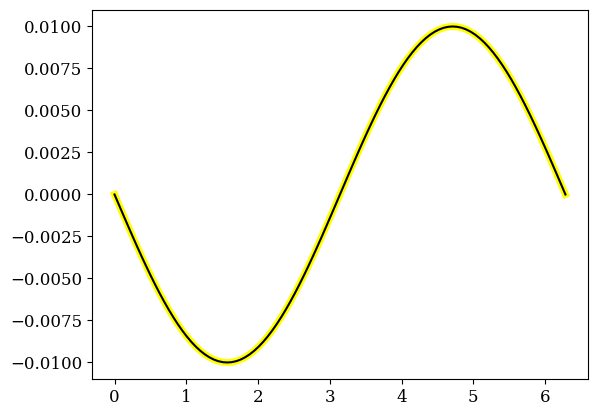

In [12]:
plt.plot(x, E_field, linewidth=5, color="yellow", label="E")
plt.plot(x, -1e-2*np.sin(x), color="black", label="Correct")

In [13]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(fft_(C_0e_coeff, Nx, x, L), psi_ln_sw((v-u_e)/alpha_e, n=0)).real
f_0i = np.outer(fft_(C_0i, Nx, x, L), psi_ln_sw((v-u_i)/alpha_i, n=0)).real

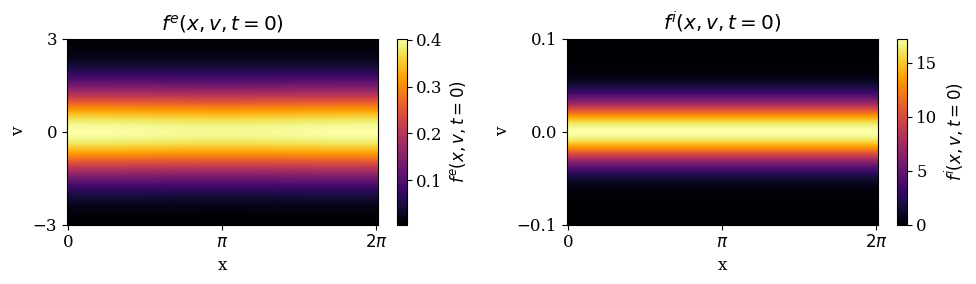

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, (f_0e**2).T, cmap="inferno")
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, (f_0i**2).T, cmap="inferno")
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("figs/SW_sqrt/linear_landau/poisson/initial_condition_landau_damping.png", dpi=600)

In [15]:
sol_midpoint_u = np.load("data/SW_sqrt/linear_landau/poisson/sol_midpoint_u_101.npy")
sol_midpoint_t = np.load("data/SW_sqrt/linear_landau/poisson/sol_midpoint_t_101.npy")
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(10202, 1001)
(1001,)


In [16]:
# initialize the electric potential
E_midpoint = np.zeros((2*Nx+1, len(sol_midpoint_t)), dtype="complex128")

In [17]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")
state_i_midpoint = np.zeros((Nv, 2*Nx+1, len(sol_midpoint_t)), dtype="complex128")


for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the linear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj * (2 * Nx + 1): (jj + 1) * (2 * Nx + 1), ii]
        state_i_midpoint[0, Nx, ii] = np.sqrt(1 / alpha_i)
        
    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii],
                                          state_i=state_i_midpoint[:, :, ii],
                                          alpha_e=alpha_e,
                                          alpha_i=alpha_i,
                                          Nx=Nx, Nv=Nv, solver="SWSR", L=L)

In [18]:
E_field = np.zeros(np.shape(E_midpoint))
for ii in range(len(sol_midpoint_t)):
    E_field[:, ii] = fft_(E_midpoint[:, ii], Nx, x, L)

In [19]:
print(E_midpoint[Nx -1, 0])
print(E_midpoint[Nx + 1, 0])

(3.8420892293630416e-17-0.004999999999999955j)
(3.8420892293630416e-17+0.004999999999999955j)


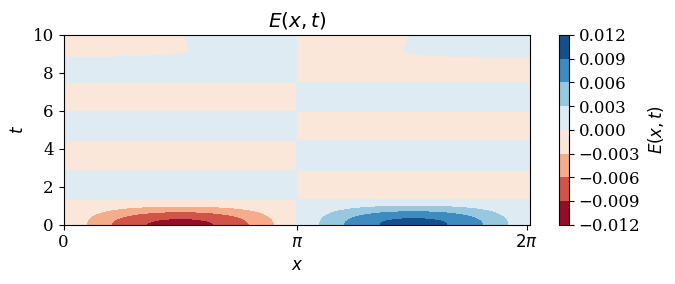

In [20]:
fig, ax = plt.subplots(figsize=(7, 3))
pos = ax.contourf(x, sol_midpoint_t, E_field.T, cmap="RdBu")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

plt.savefig("figs/SW_sqrt/linear_landau/poisson/electric_field_SW_sqrt.png", dpi=600)

In [21]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(E_midpoint[Nx+1, ii])

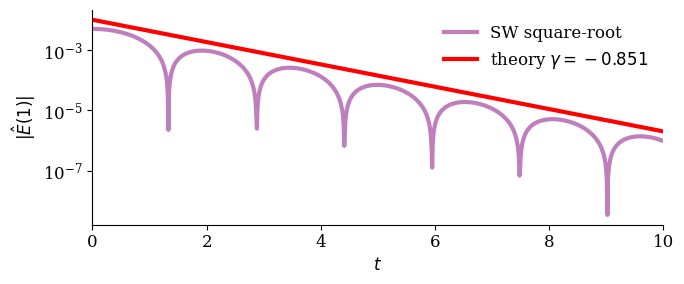

In [22]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "-", c="purple", alpha=0.5, linewidth=3, label="SW square-root") 
ax.plot(sol_midpoint_t, np.exp(-0.851*sol_midpoint_t)*1e-2, linewidth=3, color="red", label=r"theory $\gamma = -0.851$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/SW_sqrt/linear_landau/poisson/damping_rate_electric_field.png", dpi=600)

# Conservation Laws

# Mass conservation 

In [23]:
def mass(state):
    y = 0
    for nn in range(0, Nv):
        y += L * np.flip(np.conjugate(state[nn, :])).T @ np.conjugate(state[nn, :])
    return y 

In [24]:
mass_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = mass(state_e_midpoint[:, :, ii])*alpha_e + mass(state_i_midpoint[:, :, ii])*alpha_i

In [25]:
def term2(state):
    res = 0
    for nn in range(1, Nv):
        res += L * np.sqrt(nn/2)* np.flip(np.conjugate(state[nn-1, :])).T @ state[nn, :]
    return res

def term3(state):
    res = 0
    for nn in range(0, Nv-1):
        res += L * np.sqrt((nn+1)/2)* np.flip(np.conjugate(state[nn+1, :])).T @ state[nn, ii]
    return res  

In [26]:
momentum_midpoint = np.zeros(len(sol_midpoint_t), dtype="complex128")

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = m_e*alpha_e*(u_e*mass(state_e_midpoint[:, :, ii]) + alpha_e*(2*term2(state_e_midpoint[:, :, ii])))\
                          + m_i*alpha_i*(u_i*mass(state_i_midpoint[:, :, ii]) + alpha_i*(2*term2(state_i_midpoint[:, :, ii])))

### energy conservation

In [27]:
def term4(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(0, Nv):
        res += 0.5*m* np.conjugate(np.flip(state[m, :, ii])).T @ state[m, :, ii]
    return res

def term5(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(0, Nv-2):
        res += 0.5*np.sqrt((m+1)*(m+2)) * np.conjugate(np.flip(state[m, :, ii])).T @ state[m+2, :, ii]
    return res

In [28]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = L*m_e*(alpha_e**3)*(term4(state_e_midpoint, ii) + term5(state_e_midpoint, ii)).real\
                           +L*m_i*(alpha_i**3)*(term4(state_i_midpoint, ii) + term5(state_i_midpoint, ii)).real
    
    energy_p_midpoint[ii] = L*(0.5)* (np.conjugate(np.flip(E_midpoint[:, ii])).T @ E_midpoint[:, ii]).real

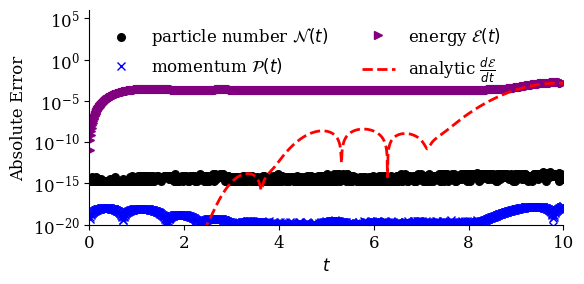

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 3))

ax.scatter(sol_midpoint_t, np.abs(mass_midpoint-mass_midpoint[0]), s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint-momentum_midpoint[0]), "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])), ">",  color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1, :]), ls="--", linewidth=2, color="red", label=r"analytic $\frac{d\mathcal{E}}{dt}$")
ax.set_ylim(10**-20, 10**6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12, loc="upper left")
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/SW_sqrt/linear_landau/poisson/mass_momentum_energy_conservation_101_linear_landau_SW_sqrt.png", dpi=600)